# Distribution of Chinese Hashrate

![](http://media.licdn.com/dms/image/v2/D4D22AQEnAEcwXHrvKg/feedshare-shrink_1280/feedshare-shrink_1280/0/1716287548057?e=1728518400&v=beta&t=90oYrsrpoTWJ0B6Ti84_dCcndcu13HeitkhgWGpPSb0)

In [1]:
!pip install joblib

In [2]:
# Import Libraries for Data Preprocessing, Modeling, and Visualization
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df= pd.read_csv('/kaggle/input/distribution-of-chinese-hashrate-by-province/export.csv')

In [4]:
df

,Date,Province,Share of Chinese hashrate
0,2019-09-01,Sichuan,49.52
1,2019-09-01,Xinjiang,19.09
2,2019-09-01,Yunnan,13.55
3,2019-09-01,Inner Mongolia,8.00
4,2019-09-01,Other,4.92
...,...,...,...
201,2021-07-01,Shanxi,0.00
202,2021-07-01,Qinghai,0.00
203,2021-07-01,Inner Mongolia,0.00
204,2021-07-01,Beijing,0.00


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df_grouped = df.groupby(['Province', df['Date'].dt.year])['Share of Chinese hashrate'].sum().reset_index()

In [6]:
# Data overview
print("Data Overview:")
print(df.head())
print(f"\nUnique Provinces: {df['Province'].nunique()}")
print(f"\nData Summary:\n{df.describe()}")

Data Overview:
        Date        Province  Share of Chinese hashrate
0 2019-09-01         Sichuan                      49.52
1 2019-09-01        Xinjiang                      19.09
2 2019-09-01          Yunnan                      13.55
3 2019-09-01  Inner Mongolia                       8.00
4 2019-09-01           Other                       4.92

Unique Provinces: 9

Data Summary:
                                Date  Share of Chinese hashrate
count                            206                 206.000000
mean   2020-08-01 03:57:40.194174720                  10.644951
min              2019-09-01 00:00:00                   0.000000
25%              2020-02-01 00:00:00                   1.120000
50%              2020-08-01 00:00:00                   4.475000
75%              2021-02-01 00:00:00                  12.450000
max              2021-07-01 00:00:00                  61.100000
std                              NaN                  14.731473


In [7]:
# Check for missing values
print("\nMissing Values Check:")
df.isnull().sum()


Missing Values Check:


Date                         0
Province                     0
Share of Chinese hashrate    0
dtype: int64

In [8]:
# Check the data to ensure it includes information for all provinces
df['Province'].unique()

array(['Sichuan', 'Xinjiang', 'Yunnan', 'Inner Mongolia', 'Other',
       'Gansu', 'Beijing', 'Shanxi', 'Qinghai'], dtype=object)

In [9]:
# Check the data types of the columns
df.dtypes

Date                         datetime64[ns]
Province                             object
Share of Chinese hashrate           float64
dtype: object

In [10]:
df.shape

(206, 3)

In [11]:
# One-Hot Encoding for categorical 'Province' feature
onehotencoder = OneHotEncoder()
X_encoded = onehotencoder.fit_transform(df_grouped[['Province']]).toarray()
X_encoded_df = pd.DataFrame(X_encoded, columns=onehotencoder.get_feature_names_out(['Province']))
df_grouped['Year'] = df_grouped['Date']

In [12]:
# Prepare features and target
X = pd.concat([X_encoded_df, df_grouped['Year']], axis=1)
y = df_grouped['Share of Chinese hashrate'].apply(lambda x: 1 if x > df_grouped['Share of Chinese hashrate'].mean() else 0)

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

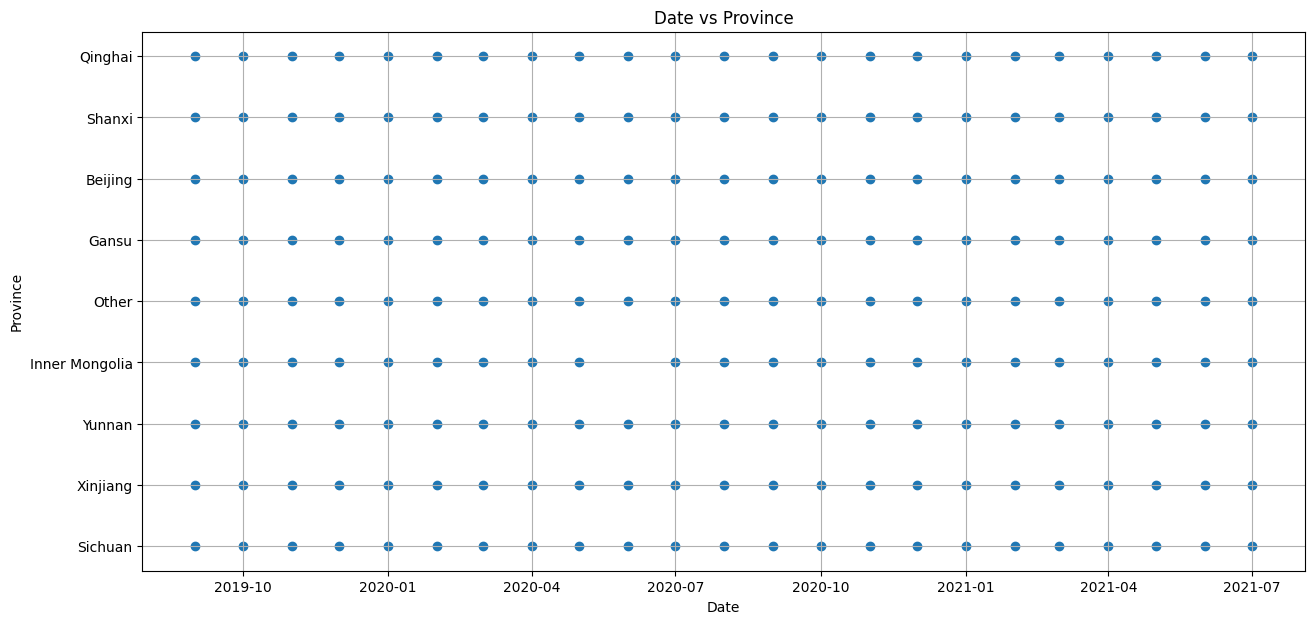

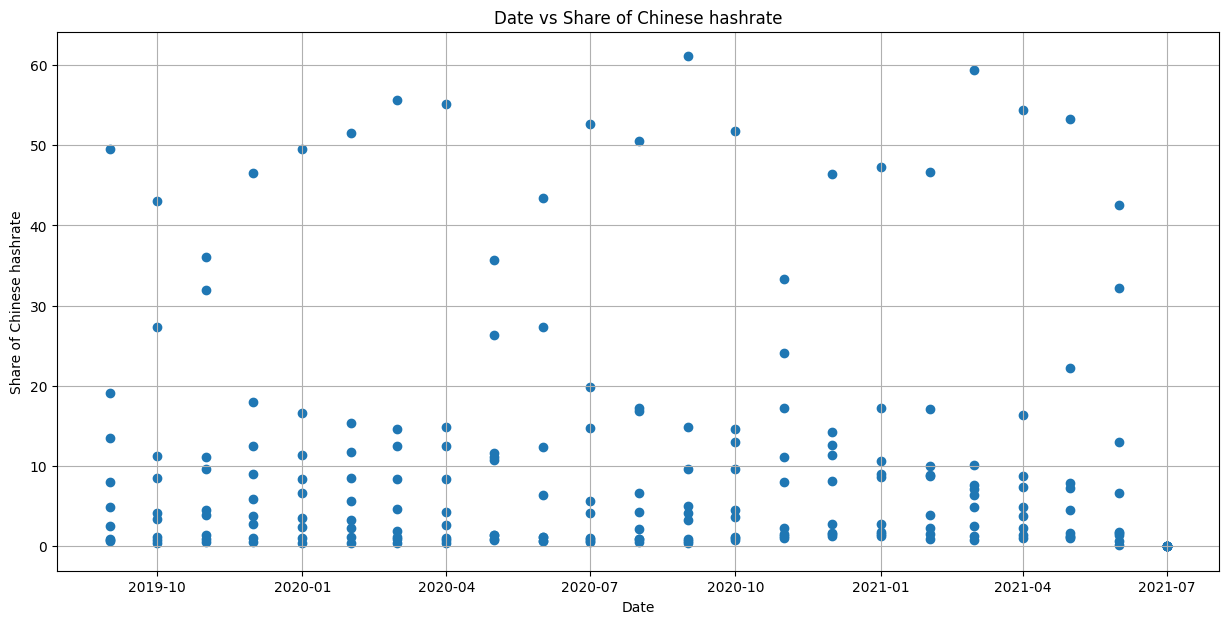

In [14]:
# Check if 'timestamp' column exists in the DataFrame
if 'Date' in df.columns:
    # Extracting column names from the DataFrame
    columns = df.columns.tolist()
    # Excluding 'timestamp' column from the list
    columns.remove('Date')
    # Plotting each column against 'timestamp' using a loop
    for col in columns:
        plt.figure(figsize=(15, 7))
        plt.scatter(df['Date'], df[col])
        plt.title(f'Date vs {col}')
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.grid(True)
        plt.show()
else:
    print("The 'Date' column does not exist in the DataFrame.")

In [15]:
# Extract the year from the 'Date' column (which is now grouped by year)
df_grouped['Year'] = df_grouped['Date']  # 'Date' has been transformed to year already during groupby
# Combine the encoded features with other numerical features (Year)
X = pd.concat([X_encoded_df, df_grouped['Year']], axis=1)
# Target variable (binarizing the hashrate share)
y = df_grouped['Share of Chinese hashrate'].apply(lambda x: 1 if x > df_grouped['Share of Chinese hashrate'].mean() else 0)

In [16]:
df_grouped_pivot = df_grouped.pivot(index='Province', columns='Date', values='Share of Chinese hashrate').fillna(0)

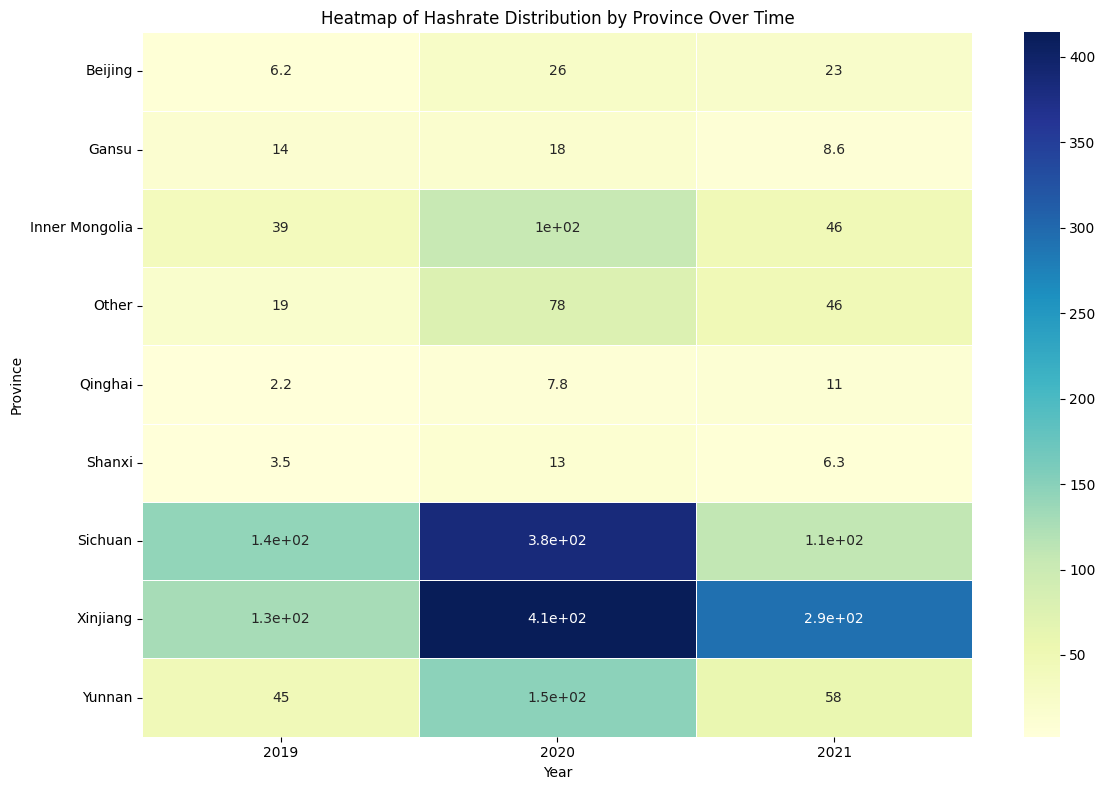

In [17]:
# Plot: Heatmap of Hashrate Distribution by Province Over Time
plt.figure(figsize=(12, 8))
sns.heatmap(df_grouped_pivot, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Hashrate Distribution by Province Over Time')
plt.xlabel('Year')
plt.ylabel('Province')
plt.tight_layout()
plt.show()

In [18]:
# Advanced line plot using Plotly
def plot_interactive_line_chart(df):
    fig = px.line(df, x='Date', y='Share of Chinese hashrate', color='Province',
                  title="Hashrate Share over Time by Province",
                  labels={'Share of Chinese hashrate': 'Hashrate (%)'},
                  markers=True)
    
    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Share of Chinese hashrate (%)",
        hovermode='x unified',
        title_x=0.5,
        #template="plotly_dark",
        font=dict(size=14),
    )
    fig.show()
plot_interactive_line_chart(df)

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [19]:
# Dynamic bar chart with slider (instead of Choropleth)
def plot_province_share_with_slider(data, column_name):
    fig = make_subplots(rows=1, cols=1, subplot_titles=(f"Bar Chart of {column_name} by Province"), specs=[[{"type": "bar"}]])

    years = sorted(data['Date'].dt.year.unique())
    
    # Loop through each year and create a bar chart for each
    for year in years:
        filtered_data = data[data['Date'].dt.year == year]
        
        # Bar chart for the same year
        bar_chart = go.Bar(
            x=filtered_data['Province'],
            y=filtered_data[column_name],
            marker=dict(color=filtered_data[column_name], colorscale='Reds', showscale=True),
            visible=False,
            name=f'{year} Data'
        )
        
        # Add bar chart to the figure
        fig.add_trace(bar_chart, row=1, col=1)

    # Show first year data by default
    fig.data[0].visible = True
    
    # Create steps for the slider
    steps = []
    for i in range(0, len(years)):
        step = dict(
            method='update',
            args=[{"visible": [False] * len(fig.data)},
                  {"title": f"{column_name} by Province - {years[i]}"}],
        )
        step["args"][0]["visible"][i] = True
        steps.append(step)

    # Add slider
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Year: "},
        pad={"t": 50},
        steps=steps
    )]

    # Update layout
    fig.update_layout(
        title=f'{column_name} Distribution by Province',
        title_x=0.5,
        sliders=sliders,
        height=600,
        width=1000,
        showlegend=False,
        xaxis_title="Province",
        yaxis_title=f'{column_name} (%)',
    )

    # Show figure
    fig.show()

# Dynamic bar chart
plot_province_share_with_slider(df, 'Share of Chinese hashrate')

In [20]:
# Adjusted to use text-based plotting since Choropleth for provinces isn't supported without GeoJSON
def plot_choropleth_map(data, column_name):
    # Mapping province names to approximate central latitudes and longitudes
    province_locations = {
        'Sichuan': {'lat': 30.663, 'lon': 104.072},
        'Xinjiang': {'lat': 43.792, 'lon': 87.617},
        'Yunnan': {'lat': 25.046, 'lon': 102.718},
        'Inner Mongolia': {'lat': 40.817, 'lon': 111.765},
        'Other': {'lat': 35.000, 'lon': 100.000},
        'Gansu': {'lat': 36.061, 'lon': 103.834},
        'Beijing': {'lat': 39.904, 'lon': 116.407},
        'Shanxi': {'lat': 37.869, 'lon': 112.558},
        'Qinghai': {'lat': 36.623, 'lon': 101.778},
    }
    
    fig = go.Figure()
    years = sorted(data['Date'].dt.year.unique())
    
    for year in years:
        filtered_data = data[data['Date'].dt.year == year]
        
        # Prepare data for the map
        latitudes = [province_locations[prov]['lat'] for prov in filtered_data['Province']]
        longitudes = [province_locations[prov]['lon'] for prov in filtered_data['Province']]
        
        # Create scatter geo plot to simulate a choropleth map with marker size proportional to hashrate share
        fig.add_trace(go.Scattergeo(
            locationmode='ISO-3',
            lat=latitudes,
            lon=longitudes,
            text=filtered_data['Province'] + ': ' + filtered_data[column_name].astype(str) + '%',
            marker=dict(
                size=filtered_data[column_name],
                color=filtered_data[column_name],
                colorscale='Reds',
                cmin=data[column_name].min(),
                cmax=data[column_name].max(),
                colorbar=dict(title=column_name),
                line_color='black',
                sizemode='area'
            ),
            name=f'{year} Data',
            visible=False
        ))
    
    # Show first year data by default
    fig.data[0].visible = True
    
    # Create steps for the slider
    steps = []
    for i in range(len(years)):
        step = dict(
            method='update',
            args=[{"visible": [False] * len(fig.data)},
                  {"title": f"Hashrate Share Map and Bar Chart - {years[i]}"}],
        )
        step["args"][0]["visible"][i] = True
        steps.append(step)
    
    # Add slider
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Year: "},
        pad={"t": 50},
        steps=steps
    )]
    
    # Update layout
    fig.update_layout(
        title=f'{column_name} Distribution by Province',
        title_x=0.5,
        geo=dict(
            scope='asia',
            showframe=False,
            showcoastlines=True,
            projection_type='mercator'
        ),
        sliders=sliders,
        height=700,
        width=1200,
        showlegend=False
    )

    # Show the figure
    fig.show()

plot_choropleth_map(df, 'Share of Chinese hashrate')

In [21]:
# Mapping province names to approximate central latitudes and longitudes
province_locations = {
    'Sichuan': {'lat': 30.663, 'lon': 104.072},
    'Xinjiang': {'lat': 43.792, 'lon': 87.617},
    'Yunnan': {'lat': 25.046, 'lon': 102.718},
    'Inner Mongolia': {'lat': 40.817, 'lon': 111.765},
    'Other': {'lat': 35.000, 'lon': 100.000},
    'Gansu': {'lat': 36.061, 'lon': 103.834},
    'Beijing': {'lat': 39.904, 'lon': 116.407},
    'Shanxi': {'lat': 37.869, 'lon': 112.558},
    'Qinghai': {'lat': 36.623, 'lon': 101.778},
}

# Dynamic choropleth map with slider using scatter points for provinces
def plot_choropleth_map_with_scatter(data, column_name):
    # Create a subplot layout for the map and bar chart
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Choropleth Scatter Map", "Bar Chart"),
                        specs=[[{"type": "scattergeo"}, {"type": "bar"}]],
                        column_widths=[0.6, 0.4])

    years = sorted(data['Date'].dt.year.unique())
    
    for year in years:
        filtered_data = data[data['Date'].dt.year == year]
        
        # Prepare data for scattergeo
        latitudes = [province_locations[prov]['lat'] for prov in filtered_data['Province']]
        longitudes = [province_locations[prov]['lon'] for prov in filtered_data['Province']]
        
        # Scattergeo map for each year
        scattergeo = go.Scattergeo(
            lat=latitudes,
            lon=longitudes,
            text=filtered_data['Province'] + ': ' + filtered_data[column_name].astype(str) + '%',
            marker=dict(
                size=filtered_data[column_name] * 2,  # Adjust size to scale with value
                color=filtered_data[column_name],
                colorscale='Reds',
                cmin=data[column_name].min(),
                cmax=data[column_name].max(),
                colorbar=dict(title=column_name),
                line_color='darkgray',
                sizemode='area'
            ),
            name=f'{year} Data',
            visible=False
        )
        
        # Add scattergeo to the figure
        fig.add_trace(scattergeo, row=1, col=1)

        # Bar chart for the same year
        bar_chart = go.Bar(
            x=filtered_data['Province'],
            y=filtered_data[column_name],
            marker=dict(color=filtered_data[column_name], colorscale='Reds', showscale=True),
            visible=False,
            name=f'{year} Data'
        )
        
        # Add bar chart
        fig.add_trace(bar_chart, row=1, col=2)

    # Show first year data by default
    fig.data[0].visible = True
    fig.data[1].visible = True
    
    # Create steps for the slider
    steps = []
    for i in range(len(years)):
        step = dict(
            method='update',
            args=[{"visible": [False] * len(fig.data)},
                  {"title": f"Hashrate Share Map and Bar Chart - {years[i]}"}],
        )
        step["args"][0]["visible"][i * 2] = True
        step["args"][0]["visible"][(i * 2) + 1] = True
        steps.append(step)

    # Add slider
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Year: "},
        pad={"t": 50},
        steps=steps
    )]

    # Update layout
    fig.update_layout(
        title=f'{column_name} Distribution by Province',
        title_x=0.5,
        geo=dict(
            scope='asia',
            showframe=False,
            showcoastlines=True,
            projection_type='mercator'
        ),
        sliders=sliders,
        height=700,
        width=1200,
        showlegend=False
    )

    fig.show()

plot_choropleth_map_with_scatter(df, 'Share of Chinese hashrate')

In [22]:
# Model Definitions
models = [
    ('LogReg', LogisticRegression()), ('SVC', SVC(probability=True)),
    ('KNN', KNeighborsClassifier()), ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()), ('AdaBoost', AdaBoostClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()), ('XGB', XGBClassifier()),
    ('LDA', LinearDiscriminantAnalysis()), ('GaussianNB', GaussianNB())
]

In [23]:
# Hyperparameter grids for selected models
param_grids = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

In [24]:
# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
# Training and Evaluation
final_model_performance = []
for name, model in models:
    if name in param_grids:
        rand_search = RandomizedSearchCV(model, param_grids[name], cv=cv_strategy, n_iter=10, scoring='accuracy', n_jobs=-1)
        rand_search.fit(X_train, y_train)
        best_model = rand_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_train)

    # Cross-validation scores
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv_strategy, scoring='accuracy')

    # Predictions and evaluation on test set
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Storing model performance
    final_model_performance.append({
        'Model': name, 'Accuracy': acc, 'Recall': recall,
        'Precision': precision, 'F1-Score': f1, 'CV Mean Accuracy': np.mean(cv_scores)
    })

    # Save the model for future use
    joblib.dump(best_model, f'{name}_best_model.pkl')

    # Display Classification Report
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    print(f"Confusion Matrix for {name}:\n", confusion_matrix(y_test, y_pred))

Classification Report for LogReg:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion Matrix for LogReg:
 [[8 0]
 [0 1]]


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Classification Report for SVC:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion Matrix for SVC:
 [[8 0]
 [0 1]]
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9

Confusion Matrix for KNN:
 [[8 0]
 [1 0]]
Classification Report for DecisionTree:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.50      1.00      0.67     

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Classification Report for RandomForest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion Matrix for RandomForest:
 [[8 0]
 [0 1]]
Classification Report for AdaBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion Matrix for AdaBoost:
 [[8 0]
 [0 1]]
Classification Report for GradientBoosting:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1    

In [26]:
# Performance Summary
performance_df_final = pd.DataFrame(final_model_performance).sort_values(by=['Accuracy', 'F1-Score'], ascending=False)
print("\nFinal Model Performance Comparison:\n", performance_df_final)


Final Model Performance Comparison:
               Model  Accuracy  Recall  Precision  F1-Score  CV Mean Accuracy
0            LogReg  1.000000     1.0        1.0  1.000000          0.716667
1               SVC  1.000000     1.0        1.0  1.000000          0.883333
4      RandomForest  1.000000     1.0        1.0  1.000000          0.633333
5          AdaBoost  1.000000     1.0        1.0  1.000000          0.516667
3      DecisionTree  0.888889     1.0        0.5  0.666667          0.783333
6  GradientBoosting  0.888889     1.0        0.5  0.666667          0.783333
8               LDA  0.888889     1.0        0.5  0.666667          0.733333
9        GaussianNB  0.888889     1.0        0.5  0.666667          0.516667
2               KNN  0.888889     0.0        0.0  0.000000          0.566667
7               XGB  0.666667     0.0        0.0  0.000000          0.616667


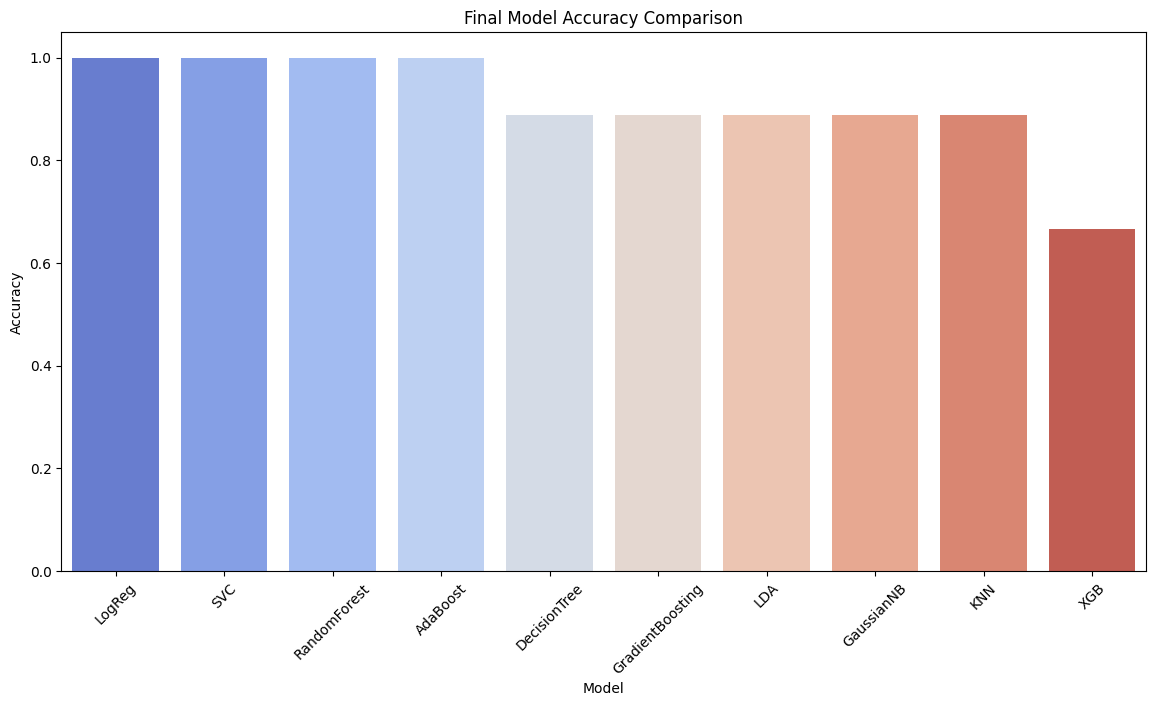

In [27]:
# Visualizing the performance of the models
plt.figure(figsize=(14, 7))
sns.barplot(x='Model', y='Accuracy', data=performance_df_final, palette='coolwarm')
plt.title('Final Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

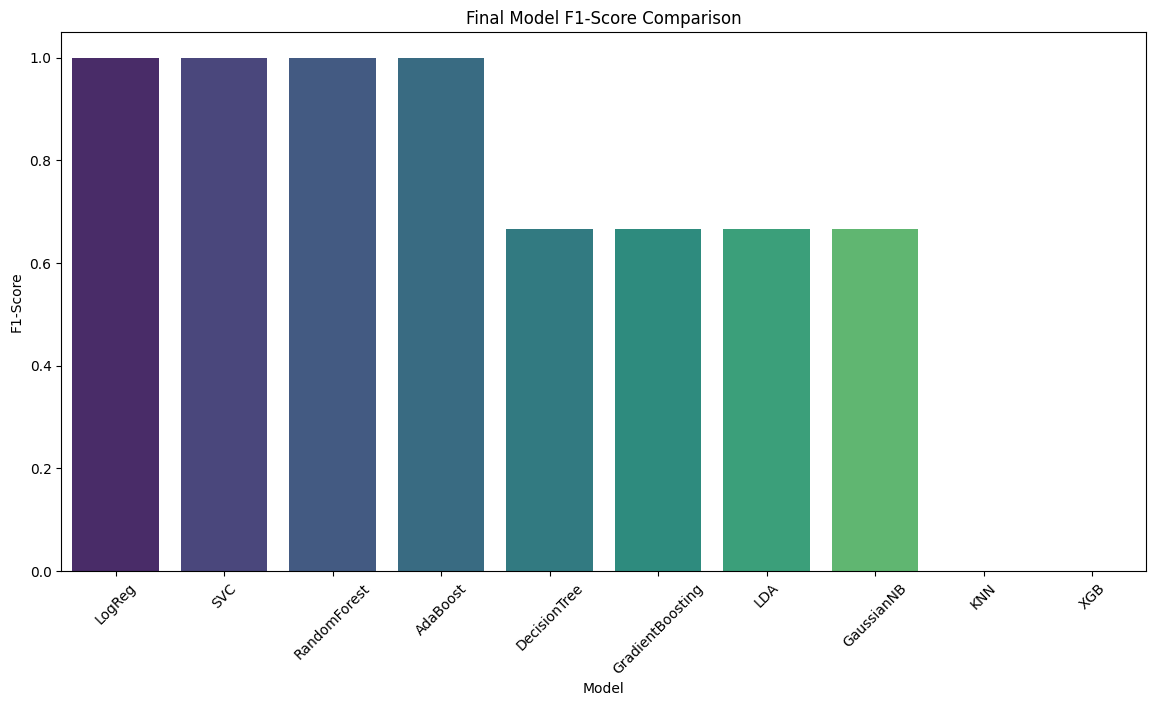

In [28]:
plt.figure(figsize=(14, 7))
sns.barplot(x='Model', y='F1-Score', data=performance_df_final, palette='viridis')
plt.title('Final Model F1-Score Comparison')
plt.xticks(rotation=45)
plt.show()

In [29]:
# Train and save the SVC model with probability=True
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)
joblib.dump(svc_model, 'SVC_best_model_with_proba.pkl')  

['SVC_best_model_with_proba.pkl']

In [30]:
# Save to a specific path
joblib.dump(svc_model, '/kaggle/working/SVC_best_model_with_proba.pkl')

# Load from the same path
voting_clf = VotingClassifier(estimators=[
    ('LogReg', joblib.load('/kaggle/working/LogReg_best_model.pkl')),
    ('SVC', joblib.load('/kaggle/working/SVC_best_model_with_proba.pkl')),
    ('GradientBoosting', joblib.load('/kaggle/working/GradientBoosting_best_model.pkl')),
    ('RandomForest', joblib.load('/kaggle/working/RandomForest_best_model.pkl'))
], voting='soft')

In [31]:
# Re-train models and save them
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
joblib.dump(logreg_model, '/kaggle/working/LogReg_best_model.pkl')

# Similarly for other models
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)
joblib.dump(svc_model, '/kaggle/working/SVC_best_model_with_proba.pkl')

# GradientBoosting and RandomForest
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
joblib.dump(gb_model, '/kaggle/working/GradientBoosting_best_model.pkl')

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, '/kaggle/working/RandomForest_best_model.pkl')

['/kaggle/working/RandomForest_best_model.pkl']

In [32]:
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

In [33]:
import os
print(os.listdir('/kaggle/working/'))

['XGB_best_model.pkl', 'KNN_best_model.pkl', '__notebook__.ipynb', 'AdaBoost_best_model.pkl', 'GradientBoosting_best_model.pkl', 'DecisionTree_best_model.pkl', 'LogReg_best_model.pkl', 'LDA_best_model.pkl', 'SVC_best_model.pkl', 'RandomForest_best_model.pkl', 'SVC_best_model_with_proba.pkl', 'GaussianNB_best_model.pkl']


In [34]:
voting_clf = VotingClassifier(estimators=[
    ('LogReg', joblib.load('/kaggle/working/LogReg_best_model.pkl')),
    ('SVC', joblib.load('/kaggle/working/SVC_best_model_with_proba.pkl')),
    ('GradientBoosting', joblib.load('/kaggle/working/GradientBoosting_best_model.pkl')),
    ('RandomForest', joblib.load('/kaggle/working/RandomForest_best_model.pkl'))
], voting='soft')

# Train the voting classifier and evaluate
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the voting classifier
acc_voting = accuracy_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

print(f"\nVoting Classifier Performance: Accuracy = {acc_voting}, Recall = {recall_voting}, Precision = {precision_voting}, F1-Score = {f1_voting}")


Voting Classifier Performance: Accuracy = 0.8888888888888888, Recall = 1.0, Precision = 0.5, F1-Score = 0.6666666666666666


In [35]:
# Voting Classifier Performance
acc_voting = accuracy_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

In [36]:
# Display Voting Classifier Results
print(f"\nVoting Classifier Performance: Accuracy = {acc_voting}, Recall = {recall_voting}, Precision = {precision_voting}, F1-Score = {f1_voting}")


Voting Classifier Performance: Accuracy = 0.8888888888888888, Recall = 1.0, Precision = 0.5, F1-Score = 0.6666666666666666


In [37]:
# Convert results to DataFrame for further analysis
performance_df_final = pd.DataFrame(final_model_performance)
performance_df_final = performance_df_final.sort_values(by=['Accuracy', 'F1-Score'], ascending=False)

In [38]:
# Display final performance
print("\nFinal Model Performance Comparison:\n", performance_df_final)


Final Model Performance Comparison:
               Model  Accuracy  Recall  Precision  F1-Score  CV Mean Accuracy
0            LogReg  1.000000     1.0        1.0  1.000000          0.716667
1               SVC  1.000000     1.0        1.0  1.000000          0.883333
4      RandomForest  1.000000     1.0        1.0  1.000000          0.633333
5          AdaBoost  1.000000     1.0        1.0  1.000000          0.516667
3      DecisionTree  0.888889     1.0        0.5  0.666667          0.783333
6  GradientBoosting  0.888889     1.0        0.5  0.666667          0.783333
8               LDA  0.888889     1.0        0.5  0.666667          0.733333
9        GaussianNB  0.888889     1.0        0.5  0.666667          0.516667
2               KNN  0.888889     0.0        0.0  0.000000          0.566667
7               XGB  0.666667     0.0        0.0  0.000000          0.616667


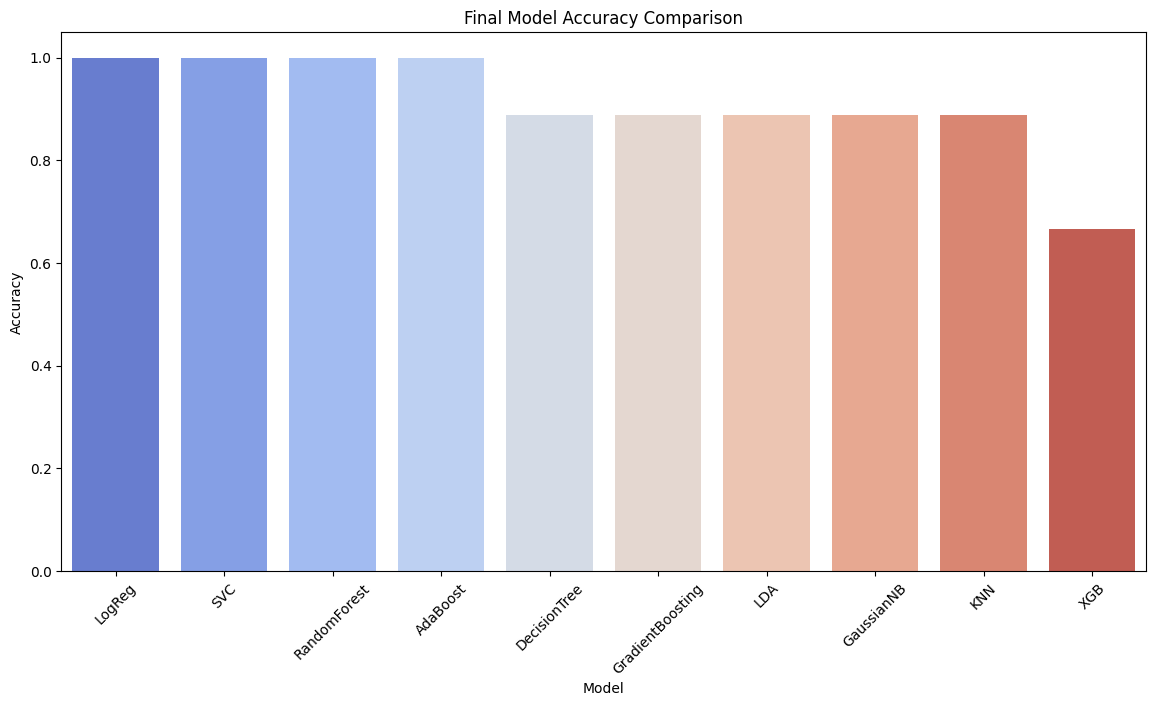

In [39]:
# Plot the model performance
plt.figure(figsize=(14, 7))
sns.barplot(x='Model', y='Accuracy', data=performance_df_final, palette='coolwarm')
plt.title('Final Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

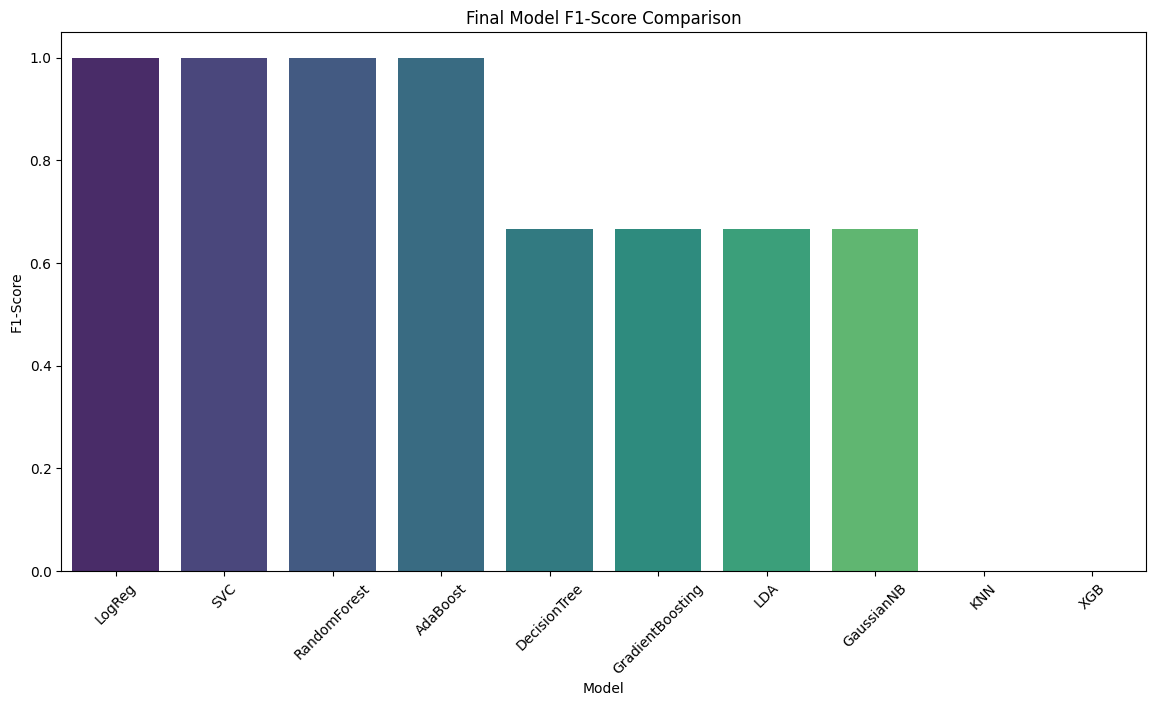

In [40]:
plt.figure(figsize=(14, 7))
sns.barplot(x='Model', y='F1-Score', data=performance_df_final, palette='viridis')
plt.title('Final Model F1-Score Comparison')
plt.xticks(rotation=45)
plt.show()

In [41]:
# Update SVC with probability=True
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)

# Save the SVC model with probability=True
joblib.dump(svc_model, 'SVC_best_model_with_proba.pkl')

['SVC_best_model_with_proba.pkl']

In [42]:
# Load the saved models, including the SVC model with probability=True
voting_clf = VotingClassifier(estimators=[
    ('LogReg', joblib.load('LogReg_best_model.pkl')),
    ('SVC', joblib.load('SVC_best_model_with_proba.pkl')),  # Loading the retrained SVC model
    ('GradientBoosting', joblib.load('GradientBoosting_best_model.pkl')),
    ('RandomForest', joblib.load('RandomForest_best_model.pkl'))
], voting='soft')

In [43]:
# Train the voting classifier and evaluate
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

In [44]:
# Voting classifier performance
acc_voting = accuracy_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

In [45]:
# Display the performance of the voting classifier
print(f"\nVoting Classifier Performance: Accuracy = {acc_voting}, Recall = {recall_voting}, Precision = {precision_voting}, F1-Score = {f1_voting}")


Voting Classifier Performance: Accuracy = 0.8888888888888888, Recall = 1.0, Precision = 0.5, F1-Score = 0.6666666666666666


In [46]:
# Function to check for overfitting by comparing train and test accuracy
def check_overfitting(model, X_train, y_train, X_test, y_test):
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    print(f"{model.__class__.__name__} - Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
    return train_accuracy, test_accuracy

In [47]:
# Train and evaluate models with train-test comparison
for name, model in models:
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_train)

    # Evaluate train and test performance
    train_acc = best_model.score(X_train, y_train)
    test_acc = best_model.score(X_test, y_test)
    
    print(f"{name} - Train Accuracy: {train_acc}, Test Accuracy: {test_acc}")
    
    # Overfitting check
    train_accuracy, test_accuracy = check_overfitting(best_model, X_train, y_train, X_test, y_test)

LogReg - Train Accuracy: 0.8888888888888888, Test Accuracy: 1.0
LogisticRegression - Train Accuracy: 0.8888888888888888, Test Accuracy: 1.0
SVC - Train Accuracy: 0.8888888888888888, Test Accuracy: 1.0
SVC - Train Accuracy: 0.8888888888888888, Test Accuracy: 1.0
KNN - Train Accuracy: 0.7777777777777778, Test Accuracy: 0.8888888888888888
KNeighborsClassifier - Train Accuracy: 0.7777777777777778, Test Accuracy: 0.8888888888888888
DecisionTree - Train Accuracy: 1.0, Test Accuracy: 0.8888888888888888
DecisionTreeClassifier - Train Accuracy: 1.0, Test Accuracy: 0.8888888888888888
RandomForest - Train Accuracy: 1.0, Test Accuracy: 0.8888888888888888
RandomForestClassifier - Train Accuracy: 1.0, Test Accuracy: 0.8888888888888888
AdaBoost - Train Accuracy: 1.0, Test Accuracy: 1.0
AdaBoostClassifier - Train Accuracy: 1.0, Test Accuracy: 1.0
GradientBoosting - Train Accuracy: 0.8888888888888888, Test Accuracy: 1.0
GradientBoostingClassifier - Train Accuracy: 0.8888888888888888, Test Accuracy: 1.0

In [48]:
# Function to check for overfitting by comparing train and test accuracy
def check_overfitting(model, X_train, y_train, X_test, y_test):
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    print(f"{model.__class__.__name__} - Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")
    return train_accuracy, test_accuracy

# List to store overfitting results
overfitting_results = []

# Train and evaluate models with train-test comparison
for name, model in models:
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_train)
    
    # Evaluate train and test performance
    train_acc = best_model.score(X_train, y_train)
    test_acc = best_model.score(X_test, y_test)
    
    # Overfitting check
    train_accuracy, test_accuracy = check_overfitting(best_model, X_train, y_train, X_test, y_test)
    
    # Store the overfitting results
    overfitting_results.append({
        'Model': name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Overfitting': train_accuracy - test_accuracy  # Higher values indicate overfitting
    })

# Convert results to DataFrame for easier viewing
overfitting_df = pd.DataFrame(overfitting_results).sort_values(by='Overfitting', ascending=True)
print("\nOverfitting Results:\n", overfitting_df)

LogisticRegression - Train Accuracy: 0.8888888888888888, Test Accuracy: 1.0
SVC - Train Accuracy: 0.8888888888888888, Test Accuracy: 1.0
KNeighborsClassifier - Train Accuracy: 0.7777777777777778, Test Accuracy: 0.8888888888888888
DecisionTreeClassifier - Train Accuracy: 1.0, Test Accuracy: 0.8888888888888888
RandomForestClassifier - Train Accuracy: 1.0, Test Accuracy: 0.7777777777777778
AdaBoostClassifier - Train Accuracy: 1.0, Test Accuracy: 1.0
GradientBoostingClassifier - Train Accuracy: 0.8888888888888888, Test Accuracy: 1.0
XGBClassifier - Train Accuracy: 0.6666666666666666, Test Accuracy: 0.6666666666666666
LinearDiscriminantAnalysis - Train Accuracy: 0.9444444444444444, Test Accuracy: 0.8888888888888888
GaussianNB - Train Accuracy: 0.8333333333333334, Test Accuracy: 0.8888888888888888

Overfitting Results:
               Model  Train Accuracy  Test Accuracy  Overfitting
0            LogReg        0.888889       1.000000    -0.111111
1               SVC        0.888889       1.00

# THE BEST MODEL IS: 
### AdaBoost - Train Accuracy: 1.0, Test Accuracy: 1.0

##### AdaBoostClassifier is the best model in this scenario since it has a perfect Train Accuracy (1.0) and Test Accuracy (1.0), indicating excellent performance without overfitting.**

---------------------------------------------------------------------------------------------------------

**LogisticRegression, SVC, and GradientBoostingClassifier show good generalization with 100% Test Accuracy and slightly lower Train Accuracy, which is typically a good sign that they are not overfitting.**

**Models like DecisionTree and RandomForest may be overfitting since they have perfect Train Accuracy but slightly lower Test Accuracy.**

### AdaBoost achieves perfect accuracy on both training and test sets, meaning no overfitting.
### This is an ideal case where the model performs equally well on both training and test data, making it the best model.

![](http://miro.medium.com/v2/resize:fit:828/format:webp/0*eohJMQXGUYR9mJQQ.png)

# What is AdaBoost?
AdaBoost is a supervised learning algorithm that is used for classification purposes. The algorithm is a meta-learner that is often used as a base learning algorithm to build more complex models.

The AdaBoost algorithm, which stands for Adaptive Boosting, is a boosting strategy that is applied in machine learning as part of an Ensemble Method. It is given the name “Adaptive Boosting” because of the fact that the weights are reallocated to each instance, with higher weights being applied to instances that were mistakenly categorized. Boosting is an approach to supervised learning that can reduce bias while also reducing variance.



![](http://ars.els-cdn.com/content/image/3-s2.0-B9780128177365000090-f09-18-9780128177365.jpg)